In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as img
from PIL import Image
import seaborn as sns

In [ ]:
#Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed' ) >= 0:  
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Aug 31 11:01:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !pip install tensorflow==2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.4 MB/s 
     |████████████████████████████████| 1.6 MB 44.0 MB/s 


In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner import BayesianOptimization
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import multilabel_confusion_matrix
import keras_tuner

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  """


In [ ]:
keras.backend.clear_session()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/Dissertation')

In [ ]:
# Load the Train and Test Directories
train_dir = '/content/gdrive/My Drive/Dissertation/Tumour/Training'
test_dir  = '/content/gdrive/My Drive/Dissertation/Tumour/Testing'

(512, 512, 3)


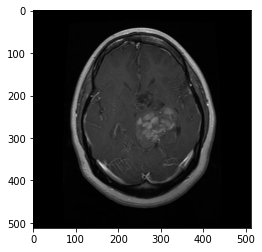

In [ ]:
# Glioma Tumor visualization
img_array = img.imread(train_dir + "/glioma_tumor/gg (1).jpg")
input_shape = img_array.shape
print(input_shape)
plt.imshow(img_array)

In [ ]:
# Load the Train and Test Directories for the cropped images
train_dir = '/content/gdrive/My Drive/Dissertation/Tumour/Train_crop'
test_dir  = '/content/gdrive/My Drive/Dissertation/Tumour/Test_crop'

In [ ]:
# Datagenerator for Train,Validation and Test

Generator = ImageDataGenerator(rescale = 1./255,
                               validation_split = 0.25,
                               shear_range=30,
                               zoom_range=.15,
                               rotation_range=30,
                              #  width_shift_range=0.05,
                              #  height_shift_range=0.05,
                               horizontal_flip=True,
                               vertical_flip = True,
                              #  brightness_range = (0.2,2.5),
                              preprocessing_function=preprocess_input)
target_labels = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

In [ ]:
train_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size=32,
                                                color_mode ='rgb',
                                                class_mode='categorical',
                                                classes=target_labels,
                                                # shuffle = True,
                                                seed = 2000,
                                                subset = 'training')   
valid_generator = Generator.flow_from_directory(train_dir,
                                                target_size=(224,224),
                                                batch_size = 32,
                                                color_mode ='rgb',
                                                class_mode = 'categorical',
                                                classes = target_labels,
                                                # shuffle = True,
                                                seed = 2000,
                                                subset = 'validation')
test_generator = Generator.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               color_mode='rgb',
                                               class_mode = 'categorical',
                                              #  shuffle = True,
                                               seed = 2000,
                                               classes=target_labels)
print("Training batch classes: ", train_generator.class_indices)
print("Validation batch classes: ", valid_generator.class_indices)
print("Validation batch classes: ", test_generator.class_indices)

Found 2155 images belonging to 4 classes.
Found 715 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Training batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation batch classes:  {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [ ]:
def plot_cf_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 14):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes,cmap='YlOrBr')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class : " + class_label)

In [ ]:
# Plot confusion matrix 
def plot_confusion_matrices(conf_matrices, target_labels):
    fig, ax = plt.subplots(1, len(target_labels), figsize = (20, 4))

    for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrices, target_labels):
        plot_cf_matrix(cfs_matrix, axes, label, ["No", "Yes"])

    fig.tight_layout()
    plt.show()

In [ ]:
# Test function
def test_model(model, test_gen):
    y_pred = model.predict(x = test_generator, verbose = 1)
    print(y_pred.shape)
    return y_pred

<h2><b>VGG16 implementation</b></h2>

In [ ]:
VGG16 = Sequential()
Con_base = keras.applications.VGG16(include_top=False,
                                        input_shape=(224,224,3),
                                        pooling='max',
                                        classes=4,
                                        weights='imagenet')
for layer in Con_base.layers:
  layer.trainable = False

VGG16.add(Con_base)
VGG16.add(Flatten())
VGG16.add(Dense(4096,activation='relu'))
VGG16.add(Dropout(0.2))
VGG16.add(Dense(4096,activation='relu'))
VGG16.add(Dropout(0.2))
VGG16.add(Dense(1000,activation='relu'))
VGG16.add(Dropout(0.5))
VGG16.add(Dense(len(target_labels),activation='softmax'))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
VGG16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 4096)              2101248   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 1000)              4

In [ ]:
VGG16.compile(optimizer=keras.optimizers.Adam(0.0001),
               loss=keras.losses.categorical_crossentropy,
               metrics=['categorical_accuracy','Recall'])

In [ ]:
mdck_cb = keras.callbacks.ModelCheckpoint(filepath='VGG16.h5')
stop_cb = keras.callbacks.EarlyStopping(patience=45)

In [ ]:
histVGG = VGG16.fit(train_generator,
                     steps_per_epoch=len(train_generator),
                     epochs=50,
                     validation_data=valid_generator,
                     validation_steps=len(valid_generator),
                     callbacks=[stop_cb,mdck_cb])

Epoch 1/50
68/68 [==============================] - 899s 13s/step - loss: 1.2405 - categorical_accuracy: 0.4469 - recall: 0.2176 - val_loss: 0.9929 - val_categorical_accuracy: 0.5580 - val_recall: 0.3944
Epoch 2/50
68/68 [==============================] - 44s 649ms/step - loss: 0.9312 - categorical_accuracy: 0.6116 - recall: 0.4543 - val_loss: 0.8198 - val_categorical_accuracy: 0.6545 - val_recall: 0.5622
Epoch 3/50
68/68 [==============================] - 43s 636ms/step - loss: 0.7983 - categorical_accuracy: 0.6742 - recall: 0.5810 - val_loss: 0.7267 - val_categorical_accuracy: 0.7049 - val_recall: 0.5888
Epoch 4/50
68/68 [==============================] - 44s 639ms/step - loss: 0.7577 - categorical_accuracy: 0.6928 - recall: 0.6125 - val_loss: 0.8308 - val_categorical_accuracy: 0.6503 - val_recall: 0.5497
Epoch 5/50
68/68 [==============================] - 44s 650ms/step - loss: 0.7022 - categorical_accuracy: 0.7262 - recall: 0.6608 - val_loss: 0.7544 - val_categorical_accuracy: 0.65

In [ ]:
X = pd.DataFrame(histVGG.history)
print('validation accuracy',max(X['val_categorical_accuracy']))
print('Training accuracy',max(X['categorical_accuracy']))
print('Validation Recall:',max(X['val_recall']))
print('Training Recall:',max(X['recall']))

validation accuracy 0.7972028255462646
Training accuracy 0.8380510210990906
Validation Recall: 0.7664335370063782
Training Recall: 0.812993049621582


In [ ]:
X.to_csv('VGG-TL.csv')

cp: cannot stat 'data.csv': No such file or directory


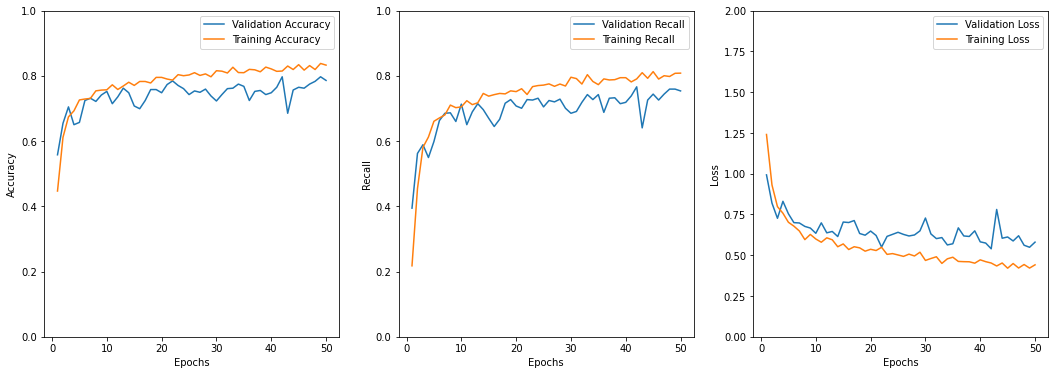

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['val_categorical_accuracy'],label='Validation Accuracy')
plt.plot(np.arange(1,len(X)+1),X['categorical_accuracy'],label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['val_recall'],label='Validation Recall')
plt.plot(np.arange(1,len(X)+1),X['recall'],label='Training Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['val_loss'],label='Validation Loss')
plt.plot(np.arange(1,len(X)+1),X['loss'],label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)
plt.legend()

In [ ]:
labelBinarizer = LabelBinarizer()
test_labels = labelBinarizer.fit_transform(test_generator.labels)

In [ ]:
# Test function
def test_model(model, test_gen):
    y_pred = model.predict(x = test_generator, verbose = 1)
    print(y_pred.shape)
    return y_pred

In [ ]:
y_pred = test_model(VGG16, test_generator)
# y_pred = test_model(model, test_generator)

In [ ]:
Y_pred = (y_pred > 0.5).astype(int)

In [ ]:
model = keras.models.load_model('/content/gdrive/My Drive/Dissertation/VGG16.h5')

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])

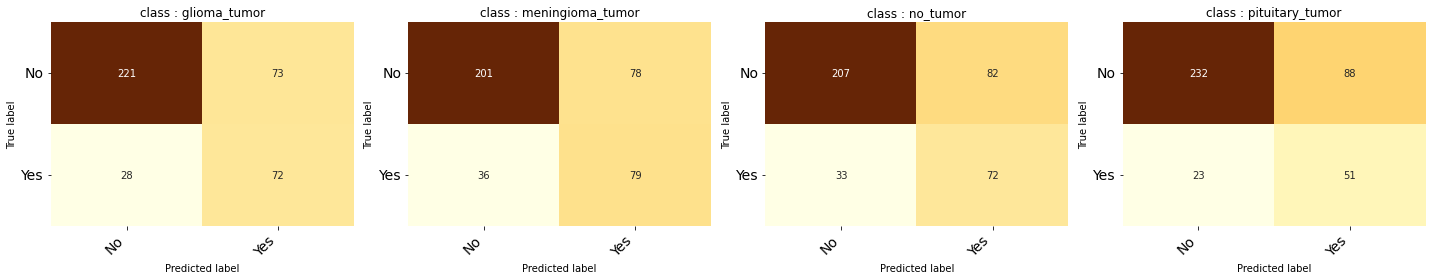

In [ ]:
plot_confusion_matrices(conf_matrices, target_labels)

<h2><b> Hyperparameter tuning of VGG16</b><h2>

In [ ]:
def build_VGG16(param):
  VGG_16 = Sequential()
  conv_bck1_filter = param.Int('Con1_fil',min_value = 64,max_value=128,step=16)
  conv_bck1_kernel = param.Choice('Con1_krn',values=[2,3,4])
  conv_bck1_stride = param.Choice('Con1_str',values=[1,2,3])
  VGG_16.add(Conv2D(filters= conv_bck1_filter, 
                    input_shape=(224,224,3), 
                    kernel_size=conv_bck1_kernel,
                    strides = conv_bck1_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())
  VGG_16.add(Conv2D(filters=conv_bck1_filter, 
                    kernel_size=conv_bck1_kernel,  
                    strides = conv_bck1_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())  
  VGG_16.add(MaxPooling2D(pool_size=param.Choice('MxP1_psz',values=[2,3,4]),
                          strides = param.Choice('MxP1_str',values=[2,3,4]),
                          padding='same'))
  conv_bck2_filter = param.Int('Con2_fil',min_value = 128,max_value=256 ,step=32)
  conv_bck2_kernel = param.Choice('Con2_krn',values=[2,3,4])
  conv_bck2_stride = param.Choice('Con2_str',values=[1,2,3])
  VGG_16.add(Conv2D(filters=conv_bck2_filter,  
                    kernel_size=conv_bck2_kernel,  
                    strides = conv_bck2_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())
  VGG_16.add(Conv2D(filters=conv_bck2_filter, 
                    kernel_size=conv_bck2_kernel,  
                    strides = conv_bck2_stride,
                    padding='same',
                    activation='relu'))  
  VGG_16.add(BatchNormalization())  
  VGG_16.add(MaxPooling2D(pool_size=param.Choice('MxP2_psz',values=[2,3,4]),
                          strides = param.Choice('MxP2_str',values=[2,3,4]),
                          padding='same'))
  conv_bck3_filter = param.Int('Con3_fil',min_value = 256,max_value=512 ,step=64)
  conv_bck3_kernel = param.Choice('Con3_krn',values=[2,3,4])
  conv_bck3_stride = param.Choice('Con3_str',values=[1,2,3])
  VGG_16.add(Conv2D(filters=conv_bck3_filter,  
                    kernel_size=conv_bck3_kernel,  
                    strides = conv_bck3_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())  
  VGG_16.add(Conv2D(filters=conv_bck3_filter,  
                    kernel_size=conv_bck3_kernel,  
                    strides = conv_bck3_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())
  VGG_16.add(Conv2D(filters=conv_bck3_filter, 
                    kernel_size=conv_bck3_kernel,  
                    strides = conv_bck3_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())    
  VGG_16.add(MaxPooling2D(pool_size=param.Choice('MxP3_psz',values=[2,3,4]),
                          strides = param.Choice('MxP3_str',values=[2,3,4]),
                          padding='same'))
  conv_bck4_filter = param.Int('Con4_fil',min_value = 512,max_value=1024 ,step=128)
  conv_bck4_kernel = param.Choice('Con4_krn',values=[2,3,4])
  conv_bck4_stride = param.Choice('Con4_str',values=[1,2,3])
  VGG_16.add(Conv2D(filters=conv_bck4_filter,  
                    kernel_size=conv_bck4_kernel,  
                    strides = conv_bck4_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())  
  VGG_16.add(Conv2D(filters=conv_bck4_filter,  
                    kernel_size=conv_bck4_kernel,  
                    strides = conv_bck4_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())
  VGG_16.add(Conv2D(filters=conv_bck4_filter, 
                    kernel_size=conv_bck4_kernel,  
                    strides = conv_bck4_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())    
  VGG_16.add(MaxPooling2D(pool_size=param.Choice('MxP4_psz',values=[2,3,4]),
                          strides = param.Choice('MxP4_str',values=[2,3,4]),
                          padding='same'))
  VGG_16.add(Conv2D(filters=conv_bck4_filter,  
                    kernel_size=conv_bck4_kernel,  
                    strides = conv_bck4_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())  
  VGG_16.add(Conv2D(filters=conv_bck4_filter,  
                    kernel_size=conv_bck4_kernel,  
                    strides = conv_bck4_stride,
                    padding='same',
                    activation='relu'))
  VGG_16.add(BatchNormalization())  
  VGG_16.add(Conv2D(filters=conv_bck4_filter, 
                    kernel_size=conv_bck4_kernel,  
                    strides = conv_bck4_stride,
                    padding='same',
                    activation='relu'))  
  VGG_16.add(BatchNormalization())  
  VGG_16.add(MaxPooling2D(pool_size=param.Choice('MxP4_psz',values=[2,3,4]),
                          strides = param.Choice('MxP4_str',values=[2,3,4]),
                          padding='same'))
  VGG_16.add(Flatten())
  VGG_16.add(Dense(units =param.Int('Dens1',min_value=3878,max_value=4598,step=128),
                     activation='relu'))
  VGG_16.add(BatchNormalization())
  VGG_16.add(Dropout(param.Choice('Dropout1',values=[0.1,0.3,0.5,0.7])))
  VGG_16.add(Dense(units =param.Int('Dens2',min_value=3878,max_value=4598,step=128),
                   activation='relu'))
  VGG_16.add(BatchNormalization())
  VGG_16.add(Dropout(param.Choice('Dropout2',values=[0.3,0.5,0.7])))
  VGG_16.add(Dense(units =param.Int('Dens3',min_value=1000,max_value=1172,step=64),
                   activation='relu'))
  VGG_16.add(BatchNormalization())
  VGG_16.add(Dropout(param.Choice('Dropout3',values=[0.4,0.6,0.8])))
  VGG_16.add(Dense(len(target_labels),activation='softmax'))
  
  VGG_16.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer= keras.optimizers.Adam(param.Choice('learning_rate',values=[5e-4,1e-4])),metrics=['categorical_accuracy','Recall'])
  return VGG_16

In [ ]:
VGG16_bo_tuner = BayesianOptimization(build_VGG16,
                            objective=[keras_tuner.Objective('val_accuracy',direction='max'),
                                       keras_tuner.Objective('val_recall',direction='max'),
                                       keras_tuner.Objective('val_loss',direction='min')],
                            max_trials=5,
                            # num_initial_points = 2,
                            # alpha = 0.0001,
                            directory ='VGG16_BO',
                            project_name='Dissert',                            
                            overwrite=True)

In [ ]:
VGG16_bo_tuner.search(train_generator,epochs=6,validation_data=valid_generator)

Trial 5 Complete [00h 03m 59s]
multi_objective: 1.4414571225643158

Best multi_objective So Far: 1.2261348813772202
Total elapsed time: 00h 44m 27s


In [ ]:
VGG16_bo_tuner.get_best_hyperparameters(1)[0].values

{'Con1_fil': 64,
 'Con1_krn': 3,
 'Con1_str': 3,
 'MxP1_psz': 3,
 'MxP1_str': 2,
 'Con2_fil': 224,
 'Con2_krn': 3,
 'Con2_str': 1,
 'MxP2_psz': 4,
 'MxP2_str': 2,
 'Con3_fil': 384,
 'Con3_krn': 2,
 'Con3_str': 2,
 'MxP3_psz': 4,
 'MxP3_str': 2,
 'Con4_fil': 768,
 'Con4_krn': 2,
 'Con4_str': 1,
 'MxP4_psz': 4,
 'MxP4_str': 2,
 'Dens1': 4134,
 'Dropout1': 0.3,
 'Dens2': 3878,
 'Dropout2': 0.7,
 'Dens3': 1000,
 'Dropout3': 0.4,
 'learning_rate': 0.0005}

In [ ]:
VGG16_bo_tuner.results_summary()

Results summary
Results in VGG16_BO/Dissert
Showing 10 best trials
Trial summary
Hyperparameters:
Con1_fil: 64
Con1_krn: 3
Con1_str: 3
MxP1_psz: 3
MxP1_str: 2
Con2_fil: 224
Con2_krn: 3
Con2_str: 1
MxP2_psz: 4
MxP2_str: 2
Con3_fil: 384
Con3_krn: 2
Con3_str: 2
MxP3_psz: 4
MxP3_str: 2
Con4_fil: 768
Con4_krn: 2
Con4_str: 1
MxP4_psz: 4
MxP4_str: 2
Dens1: 4134
Dropout1: 0.3
Dens2: 3878
Dropout2: 0.7
Dens3: 1000
Dropout3: 0.4
learning_rate: 0.0005
Score: 1.2261348813772202
Trial summary
Hyperparameters:
Con1_fil: 64
Con1_krn: 4
Con1_str: 3
MxP1_psz: 4
MxP1_str: 2
Con2_fil: 256
Con2_krn: 4
Con2_str: 1
MxP2_psz: 4
MxP2_str: 2
Con3_fil: 512
Con3_krn: 3
Con3_str: 3
MxP3_psz: 4
MxP3_str: 2
Con4_fil: 640
Con4_krn: 2
Con4_str: 1
MxP4_psz: 4
MxP4_str: 2
Dens1: 3878
Dropout1: 0.1
Dens2: 3878
Dropout2: 0.7
Dens3: 1064
Dropout3: 0.4
learning_rate: 0.0005
Score: 1.2367604076862335
Trial summary
Hyperparameters:
Con1_fil: 96
Con1_krn: 3
Con1_str: 1
MxP1_psz: 3
MxP1_str: 2
Con2_fil: 160
Con2_krn: 3
Con2_st

In [ ]:
vgg = VGG16_bo_tuner.get_best_models(5)

In [ ]:
vgg[2].summary()

In [ ]:
vgg

In [ ]:
mdck_cb = keras.callbacks.ModelCheckpoint(filepath='VGG16HP.h5')
stop_cb = keras.callbacks.EarlyStopping(patience=40)
hist000 = vgg[0].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                              epochs=50,verbose =1,
                              validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50
68/68 [==============================] - 41s 571ms/step - loss: 1.0738 - categorical_accuracy: 0.5958 - recall: 0.4984 - val_loss: 1.6399 - val_categorical_accuracy: 0.4070 - val_recall: 0.2713
Epoch 2/50
68/68 [==============================] - 39s 578ms/step - loss: 1.0166 - categorical_accuracy: 0.6097 - recall: 0.5285 - val_loss: 1.4472 - val_categorical_accuracy: 0.4867 - val_recall: 0.4126
Epoch 3/50
68/68 [==============================] - 40s 587ms/step - loss: 0.9042 - categorical_accuracy: 0.6362 - recall: 0.5689 - val_loss: 1.1813 - val_categorical_accuracy: 0.5483 - val_recall: 0.4490
Epoch 4/50
68/68 [==============================] - 37s 551ms/step - loss: 0.9143 - categorical_accuracy: 0.6432 - recall: 0.5731 - val_loss: 1.0575 - val_categorical_accuracy: 0.5804 - val_recall: 0.5077
Epoch 5/50
68/68 [==============================] - 40s 589ms/step - loss: 0.8730 - categorical_accuracy: 0.6752 - recall: 0.6000 - val_loss: 0.9115 - val_categorical_accuracy: 0.6

In [ ]:
hist001 = vgg[1].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                  epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 40s 552ms/step - loss: 1.0788 - categorical_accuracy: 0.5689 - recall: 0.4589 - val_loss: 1.6820 - val_categorical_accuracy: 0.3958 - val_recall: 0.2573
Epoch 2/50
68/68 [==============================] - 37s 549ms/step - loss: 1.0097 - categorical_accuracy: 0.6093 - recall: 0.5193 - val_loss: 1.5370 - val_categorical_accuracy: 0.4308 - val_recall: 0.2895
Epoch 3/50
68/68 [==============================] - 39s 568ms/step - loss: 1.0030 - categorical_accuracy: 0.6093 - recall: 0.5253 - val_loss: 1.1180 - val_categorical_accuracy: 0.5441 - val_recall: 0.4559
Epoch 4/50
68/68 [==============================] - 37s 545ms/step - loss: 0.9119 - categorical_accuracy: 0.6399 - recall: 0.5666 - val_loss: 1.2889 - val_categorical_accuracy: 0.5007 - val_recall: 0.4755
Epoch 5/50
68/68 [==============================] - 37s 541ms/step - loss: 0.8709 - categorical_accuracy: 0.6872 - recall: 0.6088 - val_loss: 0.9074 - val_categorical_accuracy: 0.6

In [ ]:
hist002 = vgg[2].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                  epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 50s 707ms/step - loss: 1.1892 - categorical_accuracy: 0.6162 - recall: 0.5606 - val_loss: 1.6792 - val_categorical_accuracy: 0.3524 - val_recall: 0.3441
Epoch 2/50
68/68 [==============================] - 48s 708ms/step - loss: 1.0463 - categorical_accuracy: 0.6701 - recall: 0.6283 - val_loss: 1.8069 - val_categorical_accuracy: 0.3273 - val_recall: 0.3203
Epoch 3/50
68/68 [==============================] - 50s 726ms/step - loss: 1.0099 - categorical_accuracy: 0.6710 - recall: 0.6302 - val_loss: 2.6117 - val_categorical_accuracy: 0.3315 - val_recall: 0.3259
Epoch 4/50
68/68 [==============================] - 50s 728ms/step - loss: 0.9489 - categorical_accuracy: 0.6956 - recall: 0.6575 - val_loss: 1.1106 - val_categorical_accuracy: 0.5720 - val_recall: 0.5287
Epoch 5/50
68/68 [==============================] - 50s 732ms/step - loss: 0.9481 - categorical_accuracy: 0.6803 - recall: 0.6362 - val_loss: 0.8982 - val_categorical_accuracy: 0.6

In [ ]:
hist003 = vgg[3].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                  epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 40s 562ms/step - loss: 1.0237 - categorical_accuracy: 0.6093 - recall: 0.5142 - val_loss: 1.6827 - val_categorical_accuracy: 0.4028 - val_recall: 0.1650
Epoch 2/50
68/68 [==============================] - 37s 547ms/step - loss: 0.9725 - categorical_accuracy: 0.6436 - recall: 0.5671 - val_loss: 1.4551 - val_categorical_accuracy: 0.4112 - val_recall: 0.3273
Epoch 3/50
68/68 [==============================] - 38s 556ms/step - loss: 0.9395 - categorical_accuracy: 0.6269 - recall: 0.5601 - val_loss: 1.8881 - val_categorical_accuracy: 0.3790 - val_recall: 0.3455
Epoch 4/50
68/68 [==============================] - 37s 549ms/step - loss: 0.8966 - categorical_accuracy: 0.6599 - recall: 0.5963 - val_loss: 1.4216 - val_categorical_accuracy: 0.4895 - val_recall: 0.4014
Epoch 5/50
68/68 [==============================] - 38s 554ms/step - loss: 0.8664 - categorical_accuracy: 0.6900 - recall: 0.6251 - val_loss: 1.3856 - val_categorical_accuracy: 0.4

In [ ]:
hist004 = vgg[4].fit_generator(train_generator,steps_per_epoch=len(train_generator),
                                  epochs=50,verbose =1,
                                validation_data = valid_generator,validation_steps=len(valid_generator))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
68/68 [==============================] - 40s 559ms/step - loss: 1.2106 - categorical_accuracy: 0.5081 - recall: 0.3833 - val_loss: 1.5881 - val_categorical_accuracy: 0.3483 - val_recall: 0.2881
Epoch 2/50
68/68 [==============================] - 37s 551ms/step - loss: 1.1484 - categorical_accuracy: 0.5276 - recall: 0.4190 - val_loss: 1.6906 - val_categorical_accuracy: 0.3413 - val_recall: 0.2951
Epoch 3/50
68/68 [==============================] - 37s 546ms/step - loss: 1.1502 - categorical_accuracy: 0.5429 - recall: 0.4311 - val_loss: 1.3706 - val_categorical_accuracy: 0.4294 - val_recall: 0.3944
Epoch 4/50
68/68 [==============================] - 37s 546ms/step - loss: 1.0163 - categorical_accuracy: 0.5958 - recall: 0.4905 - val_loss: 1.2451 - val_categorical_accuracy: 0.4392 - val_recall: 0.3189
Epoch 5/50
68/68 [==============================] - 38s 553ms/step - loss: 0.9781 - categorical_accuracy: 0.6292 - recall: 0.5443 - val_loss: 1.3504 - val_categorical_accuracy: 0.3

In [ ]:
Y0 = pd.DataFrame(hist000.history)
Y1 = pd.DataFrame(hist001.history)
Y2 = pd.DataFrame(hist002.history)
Y3 = pd.DataFrame(hist003.history)
Y4 = pd.DataFrame(hist004.history)

In [ ]:
Y0.to_csv('VGG00.csv')
Y1.to_csv('VGG01.csv')
Y2.to_csv('VGG02.csv')
Y3.to_csv('VGG03.csv')
Y4.to_csv('VGG04.csv')

In [11]:
X = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG-TL.csv')
Y0 = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG-trial0.csv')
Y1 = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG01.csv')
Y2 = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG-trial2.csv')
Y3 = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG03.csv')
Y4 = pd.read_csv('/content/gdrive/My Drive/Dissertation/VGG04.csv')

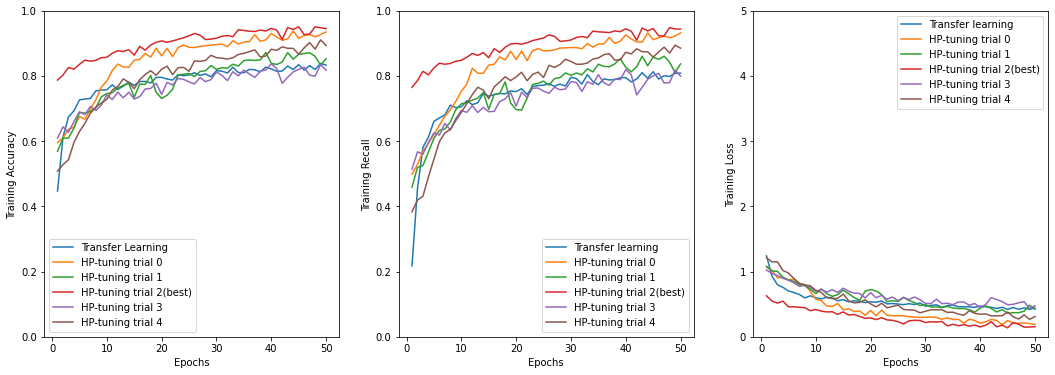

In [12]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['categorical_accuracy'],label='Transfer Learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['categorical_accuracy'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['categorical_accuracy'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['categorical_accuracy'],label='HP-tuning trial 2(best)')
plt.plot(np.arange(1,len(Y3)+1),Y3['categorical_accuracy'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['categorical_accuracy'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['recall'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['recall'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['recall'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['recall'],label='HP-tuning trial 2(best)')
plt.plot(np.arange(1,len(Y3)+1),Y3['recall'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['recall'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Training Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['loss'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['loss'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['loss'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['loss'],label='HP-tuning trial 2(best)')
plt.plot(np.arange(1,len(Y3)+1),Y3['loss'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['loss'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0,5)
plt.legend()

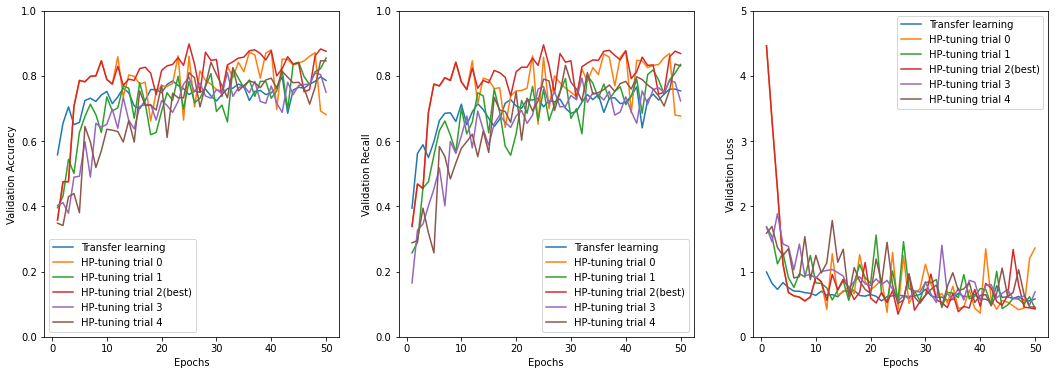

In [13]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(np.arange(1,len(X)+1),X['val_categorical_accuracy'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_categorical_accuracy'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_categorical_accuracy'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_categorical_accuracy'],label='HP-tuning trial 2(best)')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_categorical_accuracy'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_categorical_accuracy'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,2)
plt.plot(np.arange(1,len(X)+1),X['val_recall'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_recall'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_recall'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_recall'],label='HP-tuning trial 2(best)')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_recall'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_recall'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Validation Recall')
plt.ylim(0,1)
plt.legend()
plt.subplot(1,3,3)
plt.plot(np.arange(1,len(X)+1),X['val_loss'],label='Transfer learning')
plt.plot(np.arange(1,len(Y0)+1),Y0['val_loss'],label='HP-tuning trial 0')
plt.plot(np.arange(1,len(Y1)+1),Y1['val_loss'],label='HP-tuning trial 1')
plt.plot(np.arange(1,len(Y2)+1),Y2['val_loss'],label='HP-tuning trial 2(best)')
plt.plot(np.arange(1,len(Y3)+1),Y3['val_loss'],label='HP-tuning trial 3')
plt.plot(np.arange(1,len(Y4)+1),Y4['val_loss'],label='HP-tuning trial 4')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.ylim(0,5)
plt.legend()

<h3><b>Model testing

In [ ]:
y_pred = test_model(vgg[1], test_generator)

13/13 [==============================] - 134s 11s/step
(394, 4)


In [ ]:
Y_pred = (y_pred > 0.5).astype(int)

In [ ]:
labelBinarizer = LabelBinarizer()
test_labels = labelBinarizer.fit_transform(test_generator.labels)

In [ ]:
conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])

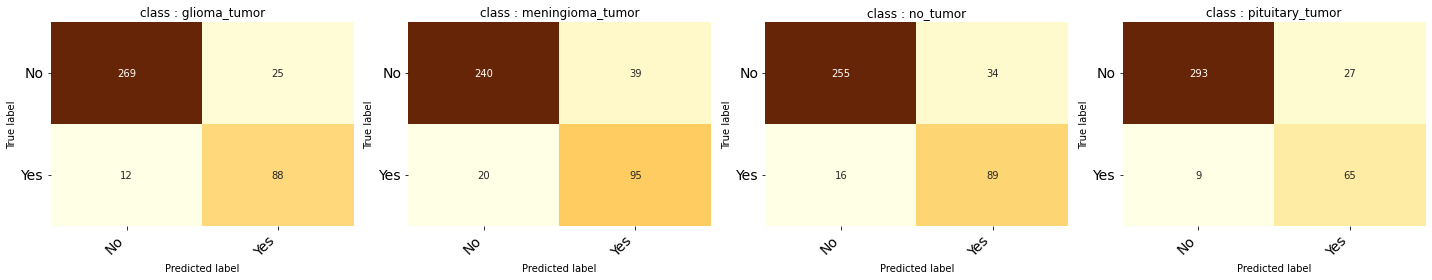

In [ ]:
plot_confusion_matrices(conf_matrices, target_labels)

In [ ]:
# model = keras.models.load_model('/content/gdrive/My Drive/Dissertation/VGG16HP.h5')
# print('Validation results: ',model.evaluate(valid_generator))
# print('Train results: ',model.evaluate(train_generator))
# print('Test results: ',model.evaluate(test_generator))